# Выбор локации для скважины

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Условие-задачи" data-toc-modified-id="Условие-задачи-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Условие задачи</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели-для-каждого-региона:" data-toc-modified-id="Обучение-и-проверка-модели-для-каждого-региона:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и проверка модели для каждого региона:</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчету-прибыли" data-toc-modified-id="Подготовка-к-расчету-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка к расчету прибыли</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Функцию-для-расчёта-прибыли-по-выбранным-скважинам-и-предсказаниям-модели:" data-toc-modified-id="Функцию-для-расчёта-прибыли-по-выбранным-скважинам-и-предсказаниям-модели:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

## Описание проекта

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль.

### Описание данных

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей)

### Условие задачи

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

##  Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import locale
locale.setlocale(locale.LC_ALL, '')

'en_US.UTF-8'

In [2]:
data_1 = pd.read_csv('geo_data_0.csv')
data_2 = pd.read_csv('geo_data_1.csv')
data_3 = pd.read_csv('geo_data_2.csv')

Удалим дубликаты записей с одинаковыми `id` и выведем общую информацию.

In [3]:
for data in [data_1, data_2, data_3]:
    data.drop_duplicates(subset=['id'], inplace=True)
    display(data.describe())
    display(data.info())

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
id         99990 non-null object
f0         99990 non-null float64
f1         99990 non-null float64
f2         99990 non-null float64
product    99990 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


None

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
id         99996 non-null object
f0         99996 non-null float64
f1         99996 non-null float64
f2         99996 non-null float64
product    99996 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


None

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
id         99996 non-null object
f0         99996 non-null float64
f1         99996 non-null float64
f2         99996 non-null float64
product    99996 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


None

### Вывод

* Пропуски и ошибки в данных отсутствуют;
* Присутствующие дубликаты были удалены уникальных `id` были удалены.

## Обучение и проверка модели для каждого региона:

In [4]:
def get_train_valid_split(data):
    
    """Создание обучающей и валидационной выборок"""
    
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345, shuffle=True)
    
    return (features_train, target_train), (features_valid, target_valid)

In [5]:
def build_model(data):
    
    """Создание и обучение модели на переданных данных
        Вывод RMSE модели и среднее количество сырья
        Возвращает модель, настроенный StandardScaler и 
        результаты предсказаний на валидационной выборке"""
    
    train, valid = get_train_valid_split(data)
    ssc = StandardScaler()
    ssc.fit(train[0])
    columns = ['f0', 'f1', 'f2']
    train[0].loc[:, columns] = ssc.transform(train[0])
    valid[0].loc[:, columns] = ssc.transform(valid[0])
    
    model = LinearRegression(n_jobs=-1)
    model.fit(*train)
    prediction = model.predict(valid[0])
    rmse = mean_squared_error(valid[1], prediction)**0.5
    
    result = np.zeros(shape=(len(prediction), 2))
    result[:, 0] = valid[1]
    result[:, 1] = prediction
    
    print(f'RMSE of the model is {rmse :.3f}')
    print(f'Средний запас предсказанного сырья: {result[:, 1].mean() : .3f}')
    print(f'Средний запас реального сырья: {result[:, 0].mean() : .3f}')

    return model, ssc, result

In [6]:
model_1, ssc_1, result_1 = build_model(data_1)

RMSE of the model is 37.854
Средний запас предсказанного сырья:  92.789
Средний запас реального сырья:  92.158


In [7]:
model_2, ssc_2, result_2 = build_model(data_2)

RMSE of the model is 0.892
Средний запас предсказанного сырья:  69.178
Средний запас реального сырья:  69.186


In [8]:
model_3, ssc_3, result_3 = build_model(data_3)

RMSE of the model is 40.076
Средний запас предсказанного сырья:  94.866
Средний запас реального сырья:  94.785


### Вывод

* Первая и третья модели демонстрируют большой показатель RMSE, модель предсказывает достаточно неточно.
* Средний запас предсказанного сырья в этих регионах 92 и 94 единицы запасов, соответственно.
* RMSE второй модели (модели второго региона) кажется идеальным, судя по всему один из признаков сильно коррелирует с предсказываемой величиной.
* Средний запас предсказанного сырья во втором регионе равен 69 единиц запасов.

## Подготовка к расчету прибыли

In [9]:
developing_cost = 10**10
income_per_unit = 4.5 * 10**5
num_of_well = 200

In [10]:
minimum_units = math.ceil(developing_cost / income_per_unit / num_of_well)
print('Необходмое количество сырья для безубыточной разработки новой скажины =', minimum_units)

Необходмое количество сырья для безубыточной разработки новой скажины = 112


### Вывод

* Необходимое количество сырья для безубыточной разработки новой скажины с учетом данного бюджета на 200 скважин составило 112 единиц запасов.
* Это значение больше любого среднего предсказанного по трем регионам.
* Нужно будет смотреть на топ скажин.

## Функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [11]:
def get_maximum_revenue(result):
    df = pd.DataFrame(result)
    df.columns = ['real', 'pred']
    df = df.sort_values(by='pred', ascending=False)
    return df['real'][:200].sum() * income_per_unit - developing_cost

In [12]:
total_income_1 = get_maximum_revenue(result_1)
total_income_2 = get_maximum_revenue(result_2)
total_income_3 = get_maximum_revenue(result_3)

print('Суммарная максимальная прибыль')
for income, name in zip([total_income_1, total_income_2, total_income_3], np.arange(1, 4)):
    print(f'Регион №{name}: {income / 10**6:n} млн. рублей')

Суммарная максимальная прибыль
Регион №1: 3,365.19 млн. рублей
Регион №2: 2,415.09 млн. рублей
Регион №3: 2,501.28 млн. рублей


In [13]:
def get_confidence_interval(result, region):
    income_real = []
    for i in range(1000):
        random_indices = np.random.choice(np.arange(0, len(result[:, 1])), (500, ),replace=True)
        random_points = result[random_indices]
        income_real.append(get_maximum_revenue(random_points) / 10**6)

    plt.hist(income_real)
    plt.title(f'[Регион {region}] Распределение выручки по реальным значениям')
    plt.show()
    
    print(f'[Регион {region}] Ожидаемая прибыль = {np.array(income_real).mean():n} млн. рублей')
    print(f'[Регион {region}] 95% доверительный интервал, млн. рублей: ({np.quantile(income_real, 0.025):n}; {np.quantile(income_real, 0.975):n})')

    for i in np.arange(0, 1, 0.0001):
        if(np.quantile(income_real, i) >= 0):
            print(f'[Регион {region}] Вероятность убытка: {i*100:.1f}%')
            break

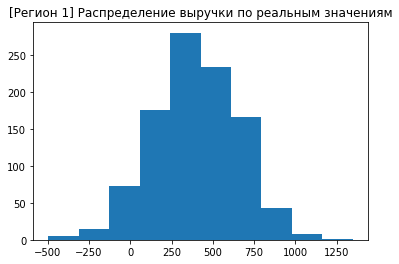

[Регион 1] Ожидаемая прибыль = 397.005 млн. рублей
[Регион 1] 95% доверительный интервал, млн. рублей: (-105.134; 872.952)
[Регион 1] Вероятность убытка: 6.6%


-.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.-



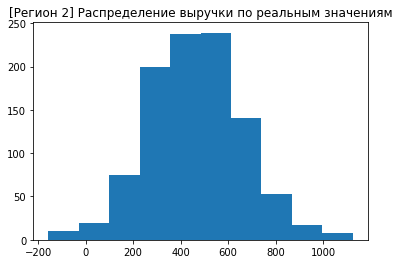

[Регион 2] Ожидаемая прибыль = 464.046 млн. рублей
[Регион 2] 95% доверительный интервал, млн. рублей: (85.9968; 867.297)
[Регион 2] Вероятность убытка: 1.1%


-.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.-



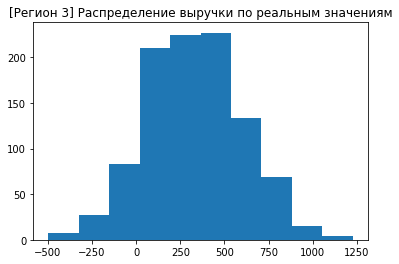

[Регион 3] Ожидаемая прибыль = 329.032 млн. рублей
[Регион 3] 95% доверительный интервал, млн. рублей: (-189.824; 853.928)
[Регион 3] Вероятность убытка: 10.1%


-.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.-



In [14]:
for result, i in zip([result_1, result_2, result_3], np.arange(1, 4)):
    get_confidence_interval(result, i)
    print('\n\n'+'-.-'*40+'\n')

### Вывод

* Единственным регионом, где вероятность убытков меньше 2.5%, является второй.
* С 95%-ой вероятностью разработка скажин во втором регионе принесет больше прибыли, чем было вложено в разработку.